1. MOUNT DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Block 2: Install & Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

Block 3: Set Paths & Read CSVs

In [ ]:

# Training + validation data
train_dir = "/content/drive/MyDrive/Colab Notebooks/p2-dataset/training images/train"
train_labels_file = "/content/drive/MyDrive/Colab Notebooks/p2-dataset/train.csv"

labels_df = pd.read_csv(train_labels_file)
labels_df.columns = labels_df.columns.str.strip()
labels_df['Label'] = labels_df['Label'].astype(str)

print(labels_df.head())
print("Total training rows:", len(labels_df))
print("Files in folder:", len(os.listdir(train_dir)))

# Test data
test_dir = "/content/drive/MyDrive/Colab Notebooks/p2-dataset/testing image/test"
test_labels_file = "/content/drive/MyDrive/Colab Notebooks/p2-dataset/test.csv"

test_labels_df = pd.read_csv(test_labels_file)
test_labels_df.columns = test_labels_df.columns.str.strip()

# Removed: test_labels_df['Label'] = test_labels_df['Label'].astype(str)
print(test_labels_df.head())
print("Total test rows:", len(test_labels_df))
print("Files in test folder:", len(os.listdir(test_dir)))

Block 4: Preprocessing & Augmentation

In [ ]:
IMG_SIZE = (299, 299)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1
)

# Training generator
train_gen = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=train_dir,
    x_col='Image',
    y_col='Label',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation generator
val_gen = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=train_dir,
    x_col='Image',
    y_col='Label',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Test generator (no augmentation or labels)
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_labels_df,
    directory=test_dir,
    x_col='Image',
    y_col=None, # Removed 'Label' as it doesn't exist in test_labels_df
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode=None, # Set to None for prediction without labels
    shuffle=False
)

Block 5: Load Pretrained Xception

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299,299,3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

Block 6: Compile Model

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Block 7: Train Model

In [ ]:
# Re-compile the model to ensure it's in a compiled state before training
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=23,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

Block 8: Save model

In [ ]:
# Save the trained model
model.save("/content/drive/MyDrive/ai_real_model.h5")
print("Model saved successfully!")

Block 9: Evaluate on Test Set

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")


Block 10: Get Predictions

In [10]:
preds = model.predict(test_gen)
pred_labels = (preds > 0.5).astype(int)

results = pd.DataFrame({
    "Image": test_labels_df['Image'],
    "Predicted_Label": pred_labels.flatten()
})

results.head()

13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


,Image,Predicted_Label
0,946.jpg,1
1,947.jpg,0
2,948.jpg,1
3,949.jpg,0
4,950.jpg,1


Block 11: Plot Training History

NameError: name 'history' is not defined

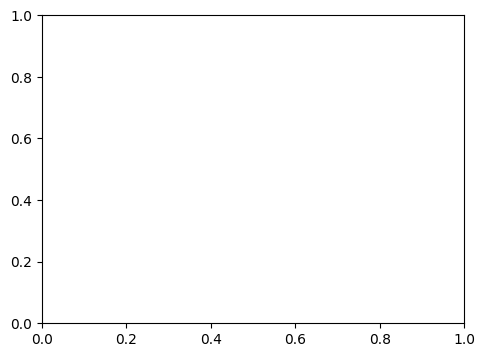

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()
